In [1]:
# https://github.com/dugusiqing/pytorch-CBAM-Res18-Mnist

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import math
import torchvision
import torch.optim as optim  # Pytoch Common optimization methods are encapsulated in torch.optim Inside 
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader

model_urls = {
    
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
}
#  Define convolution kernel 3*3,padding=1,stride=1 Convolution of , The characteristic of this convolution is that it does not change the size, But it may change channel
def conv3x3(in_channels,out_channels,stride=1):
    return nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
#  Definition CBAM Medium channel attention modular 
class ChannelAttention(nn.Module):
    #  The number of incoming input channels and compression multiple are required reduction, The default is 16
    def __init__(self,in_channels,reduction = 16):
        super(ChannelAttention,self).__init__()
        # Define the required global average pooling and global maximum pooling , Number of incoming and output channels output_size = 1
        self.avg = nn.AdaptiveAvgPool2d(output_size=1)
        self.max = nn.AdaptiveMaxPool2d(output_size=1)
        ##  Define shared perceptron MLP
        self.fc1 = nn.Conv2d(in_channels=in_channels,out_channels=in_channels//reduction,kernel_size=1,bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_channels=in_channels//reduction,out_channels=in_channels,kernel_size=1,bias=False)

        ##  Define the linear activation function 
        self.sigmod = nn.Sigmoid()
    def forward(self,x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max(x))))

        out = self.sigmod(avg_out + max_out)

        return out

##  Definition spatial attention modular 
class SpatialAttention(nn.Module):
    #  The spatial attention module has a convolution layer , Need to kernel_size
    def __init__(self,kernel_size = 7):
        super(SpatialAttention,self).__init__()
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(in_channels = 2,out_channels = 1,kernel_size=kernel_size,padding = padding,bias=False)
        self.sigmod = nn.Sigmoid()

    def forward(self,x):
        avg_out = torch.mean(x, dim = 1, keepdim = True)
        max_out, _ = torch.max(x, dim = 1, keepdim = True)
        #  take avg_out  and  max_out stay channel Stitching on dimensions 
        x = torch.cat([avg_out,max_out],dim=1)
        x = self.conv1(x)

        return self.sigmod(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self,in_channels,out_channels,stride = 1,downsample=None):
        super(BasicBlock,self).__init__()
        self.conv1 = conv3x3(in_channels,out_channels,stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels,out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # self.ca = ChannelAttention(out_channels)

        # self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self,x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # out = self.ca(out) * out
        # out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)
        out = out + residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):

    def __init__(self,block,layers,num_classes=1000):
        self.in_channels = 64
        super(ResNet,self).__init__()
        # MNIST It's a grayscale image , There's only one way , therefore in_channels = 1
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=64,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride = 2, padding = 1)
        self.layer1 = self._make_layer(block,64,layers[0])
        self.layer2 = self._make_layer(block,128,layers[1],stride=2)
        self.layer3 = self._make_layer(block,256,layers[2],stride=2)
        self.layer4 = self._make_layer(block,512,layers[3],stride=2)
        # self.Avgpool = nn.AvgPool2d(2,stride=1)
        self.fc = nn.Linear(512 * block.expansion,num_classes)
        #  Weight initialization 
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0,math.sqrt(2./n))
            elif isinstance(m,nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self,block,planes,blocks,stride = 1):
        downsample = None
        if stride != 1 or self.in_channels != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels,planes * block.expansion,
                kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(planes * block.expansion),
                
            )
        layers = []
        layers.append(block(self.in_channels,planes,stride,downsample))
        self.in_channels = planes * block.expansion
        for i in range(1,blocks):
            layers.append(block(self.in_channels,planes))
        
        return nn.Sequential(*layers)

    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # x = self.Avgpool(x) # MNIST Data sets 28*28, Is too small , Unsuitable for doing pooling
        x = x.view(x.size(0),-1)
        x = self.fc(x)

        return F.log_softmax(x,dim = 1)

def resnet18_cbam(pretrained = False,**kwargs):
    model = ResNet(BasicBlock,[2,2,2,2],**kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet18'])
        now_state_dict = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model



In [2]:
# ## 주피터 풀출력
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [3]:

batch_size_train = 64
batch_size_test = 1000
#  utilize Pytorch Built in functions mnist Download data 
#  download MNIST Training set , Save in a fixed format 
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))  # Normalize((0.1307,),(0.3081,)) Normalize the tensor   There's only one way   So there's only one dimension 
                               ])),
    batch_size=batch_size_train, shuffle=True)

#  download MNIST Test set , Save in a fixed format 
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))  # Normalize((0.1307,),(0.3081,)) Normalize the tensor   There's only one way   So there's only one dimension 
                                   #  Respectively represent the mean and variance normalized to the tensor 
                               ])),
    batch_size=batch_size_test, shuffle=True)


n_epochs = 3 
learning_rate = 0.01  #  Learning rate 
random_seed = 1  #  Random seed number 
torch.manual_seed(random_seed)  #  by CPU Set seeds to generate random numbers , So that the result is certain 




#  Implement a network 
network = resnet18_cbam(pretrained=False,num_classes = 10)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
# momentum It's a parameter   The change of the current weight will be affected by the change of the last weight ,
Step_LR = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 1,gamma=0.4)
#  Just like when the ball rolls , Because of inertia , The current state will be affected by the previous state , This can speed up .

log_interval = 10  # 10 One training batch corresponds to one training epoch
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]




In [14]:
network

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

network = network.to(device)

for epoch in range(1, n_epochs + 1):
    network.train()  #  use model.train() Will take all of module Set to training mode .
    for batch_idx, (data, target) in enumerate(train_loader):  #  Combine a traversable data object into an index sequence , List both data and data index 
        optimizer.zero_grad()  #  Gradient cleaning , because PyTorch By default, gradients are accumulated 
        data = data.to(device)
        output = network(data)  # data Is the image input value , adopt network obtain out Output value 
        target = target.to(device)
        
        
        loss = F.cross_entropy(output, target)  #  Output through the network out And the target target Compare and calculate the loss value loss
        loss.backward()  #  Error back propagation   Loss function (loss) call backward() that will do 
        optimizer.step()  #  Based on the current gradient （ Stored in the of the parameter .grad Properties of the ） Update parameters 

        if batch_idx % log_interval == 0:
            print("Train Epoch:{}[{}/{}({:.0f}]\tLoss:{:.6f})".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))  # print

            train_losses.append(loss.item())  #  This time epoch Of loss Save to train_losses list 
            train_counter.append(  #  This time epoch Of counter Save to train_counter list 
                (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))


    Step_LR.step()  #  Start learning rate decay 



# import torch.onnx
# torch.onnx.export(network,data,'./resnet_cbam.onnx',export_params=True,opset_version=12) 



Train Epoch:1[0/60000(0]	Loss:2.695870)
Train Epoch:1[640/60000(1]	Loss:1.433337)
Train Epoch:1[1280/60000(2]	Loss:0.505572)
Train Epoch:1[1920/60000(3]	Loss:0.421711)
Train Epoch:1[2560/60000(4]	Loss:0.230505)
Train Epoch:1[3200/60000(5]	Loss:0.382680)
Train Epoch:1[3840/60000(6]	Loss:0.311444)
Train Epoch:1[4480/60000(7]	Loss:0.514343)
Train Epoch:1[5120/60000(9]	Loss:0.404851)
Train Epoch:1[5760/60000(10]	Loss:0.553821)
Train Epoch:1[6400/60000(11]	Loss:0.401189)
Train Epoch:1[7040/60000(12]	Loss:0.289416)
Train Epoch:1[7680/60000(13]	Loss:0.303068)
Train Epoch:1[8320/60000(14]	Loss:0.359104)
Train Epoch:1[8960/60000(15]	Loss:0.300415)
Train Epoch:1[9600/60000(16]	Loss:0.105779)
Train Epoch:1[10240/60000(17]	Loss:0.217392)
Train Epoch:1[10880/60000(18]	Loss:0.103074)
Train Epoch:1[11520/60000(19]	Loss:0.186549)
Train Epoch:1[12160/60000(20]	Loss:0.118739)
Train Epoch:1[12800/60000(21]	Loss:0.117606)
Train Epoch:1[13440/60000(22]	Loss:0.022042)
Train Epoch:1[14080/60000(23]	Loss:0.12

In [5]:
## 평가하기
network.eval()  #  Validation phase , You need to keep the model in the validation phase , That is to call model.eval()
test_loss = 0   # loss Initial value 
correct = 0     # correct Initial value 
with torch.no_grad():  # torch.no_grad： One tensor（ Name it x） Of requires_grad = True, from x Get new tensor（ Name it w- Scalar ）requires_grad Also for the False, And grad_fn Also for the None, That's not right w Derivation 
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = network(data)  #  Computing network output  out What kind of format type is it ？
        test_loss += F.nll_loss(output, target, size_average=False).item()  #  Calculate... On the test set loss
        #  Calculate the accuracy of the classification 
        pred = output.data.max(1, keepdim=True)[1]   # pred Is the output of the predicted value of the maximum possibility for each picture 
        correct += pred.eq(target.data.view_as(pred)).sum()  #  Calculate classification accuracy 
test_loss /= len(test_loader.dataset)
test_losses.append(test_loss)
print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset))) # print
    

/data/mrjaehong/handwriting_gen/fewshot-font-generation/env/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0263, Accuracy: 9917/10000 (99%)



torch.Size([1000, 1, 28, 28]) torch.Size([1, 1, 28, 28])


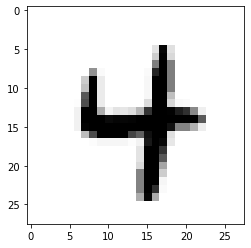

In [6]:

## CBAM에 넣을 테스트 데이터 
print(data.shape,data[1:2,:,:,:].shape)
img = data[1:2,:,:,:]
img_test = img.detach().cpu().numpy()
img_test = img_test.transpose(0,2,3,1)
img_test = img_test*255
img_test = img_test[0,:,:,:]
plt.imshow(img_test,cmap="Greys")
plt.show()



In [7]:
model_children = list(network.children())
print("모델의 구조길이 : ",len(model_children))
# 모든 레이어를 통해 이미지 전달
results = [model_children[0](img)]

## 마지막 Linear단은 곱하기가 안됨
for i in range(1, len(model_children)-1):
    # 마지막 레이어의 결과를 다음 레이어로 전달
    results.append(model_children[i](results[-1]))


## 마지막단 x = x.view(x.size(0),-1)를 똑같이 수행함
## 이거 수정해야됨
results.append(model_children[-1](results[-1].view(1,-1)))

outputs = results

모델의 구조길이 :  9


'Conv2d'

In [18]:
## 각 레이어의 필더는 64개까지만 저장 - > 너무 많이 봐봤자.... 이해 못함
for num_layer in range(len(outputs)):
    plt.figure(figsize=(16, 16),dpi=98)

    if len(outputs[num_layer].shape)==4:
        layer_viz = outputs[num_layer][0, :, :, :].detach().cpu()
        
    layer_viz = layer_viz.data
    for i, filter in enumerate(layer_viz):
        if i == 1024: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(32, 32, i + 1);
        plt.imshow(filter, cmap='Greys');
        plt.colorbar();
        plt.axis("off");
    plt.savefig(f"./layer_f_image/f_map_{model_children[num_layer]._get_name()}_{num_layer}.png");
    # plt.show()
    plt.close()

In [9]:
for item in outputs:
    print(item.shape,len(item.shape))

torch.Size([1, 64, 14, 14]) 4
torch.Size([1, 64, 14, 14]) 4
torch.Size([1, 64, 14, 14]) 4
torch.Size([1, 64, 7, 7]) 4
torch.Size([1, 64, 7, 7]) 4
torch.Size([1, 128, 4, 4]) 4
torch.Size([1, 256, 2, 2]) 4
torch.Size([1, 512, 1, 1]) 4
torch.Size([1, 10]) 2


In [10]:
torch.set_printoptions(profile="full")

last_ly = model_children[-1]

for param in last_ly.parameters():
    print("마지막 레이어 생김세(파라미터)",param.shape,)
    
    ## 선형 레이어 가중치값 프린터()
    print(param.round(decimals=3))
    
    

마지막 레이어 생김세(파라미터) torch.Size([10, 512])
tensor([[-0.0020,  0.0050, -0.0420, -0.0610, -0.0060,  0.0430, -0.0110, -0.1490,
          0.1050,  0.0500,  0.0240, -0.1850,  0.0520,  0.0800, -0.0410,  0.0800,
         -0.0680, -0.1060, -0.0400,  0.0070, -0.0350,  0.0400, -0.0390, -0.1600,
          0.1480, -0.0340,  0.0900, -0.1860,  0.1230,  0.0150, -0.0030, -0.0910,
         -0.1520, -0.0140,  0.0060, -0.0670, -0.0600,  0.0140,  0.0350, -0.0100,
          0.0220, -0.1060,  0.0150, -0.0150, -0.0450, -0.0280,  0.1110,  0.0130,
          0.0130, -0.0910,  0.0080, -0.0250,  0.0040,  0.0070,  0.0180, -0.0460,
          0.0560, -0.0040,  0.0050, -0.0570,  0.0170, -0.0160, -0.0210, -0.0350,
         -0.0050, -0.0090,  0.0230, -0.0640, -0.0300,  0.0160, -0.1080, -0.1400,
         -0.0170,  0.0210,  0.0690, -0.0060, -0.0960,  0.1760, -0.0250,  0.1670,
         -0.0210, -0.1720,  0.1350, -0.0020,  0.1630, -0.0210, -0.0130, -0.0420,
          0.0300,  0.1300,  0.0480,  0.0720,  0.0430, -0.0320, -0.023

In [11]:
## 라스트 마지막 결과값 중 가장 높은 인덱스
last_out = outputs[-1]
print(torch.argmax(last_out),"\n\n",last_out)


tensor(4, device='cuda:0') 

 tensor([[-7.4373e+00, -2.8406e+00, -3.7630e+00, -9.8693e+00,  1.7053e+01,
         -2.6570e+00,  4.0506e-01,  2.4111e-03, -4.3254e+00,  3.4125e+00]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


8


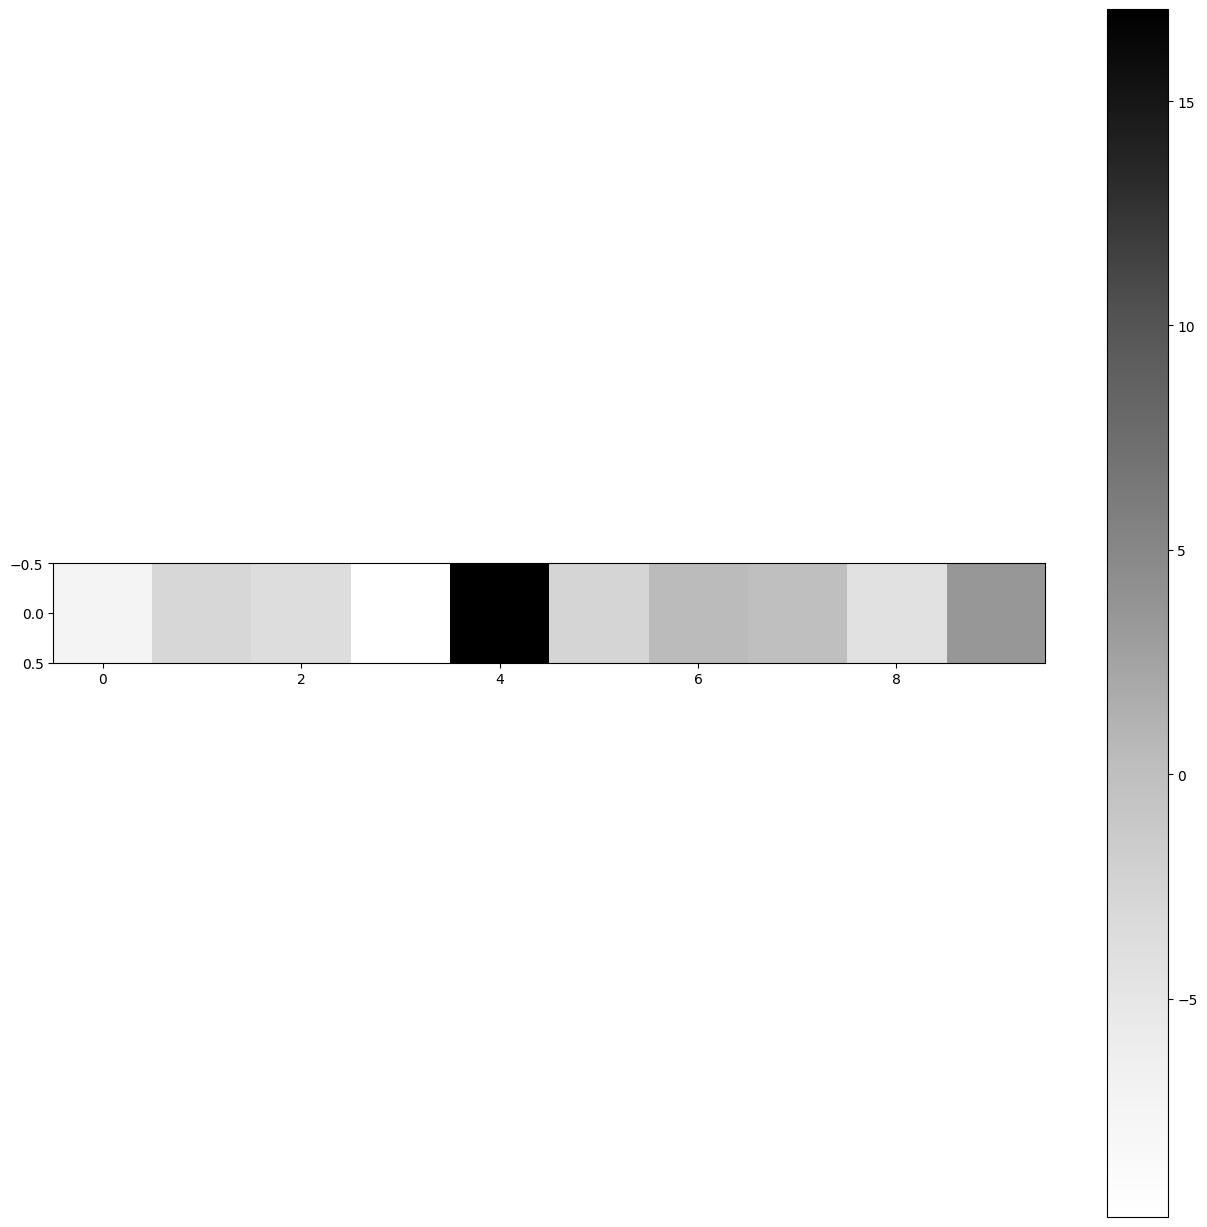

In [12]:
## 마지막 레이어 찍어보기
num_layer=8
plt.figure(figsize=(16, 16),dpi=100)

print(num_layer)
if len(outputs[num_layer].shape)==4:
    layer_viz = outputs[num_layer][0, :, :, :].detach().cpu()
else:
    layer_viz = outputs[num_layer].detach().cpu()
    layer_viz = layer_viz.data

plt.grid(False)
plt.imshow(layer_viz,cmap='Greys')
plt.colorbar()


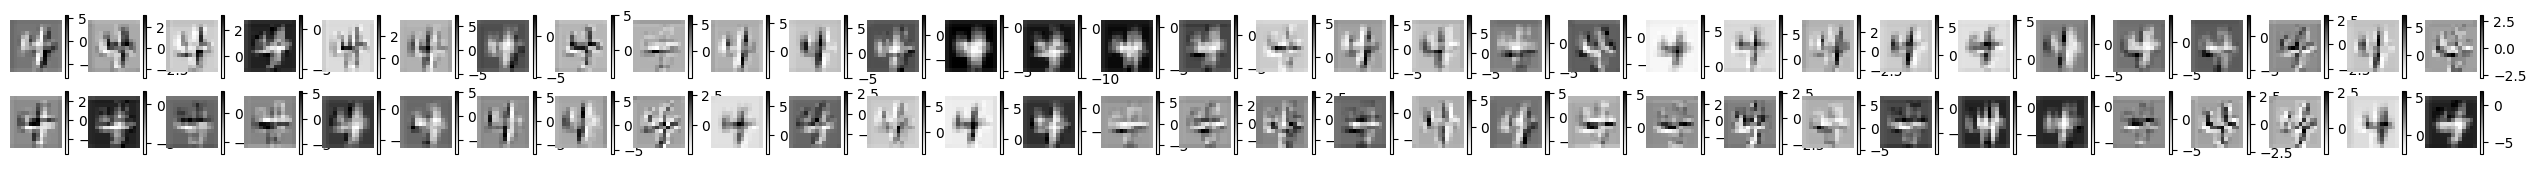

In [13]:
## 0 레이어 찍어보기
# 검은색일수록 높게 반응

num_layer=0
plt.figure(figsize=(32, 32),dpi=100)

# ## 그리드 스펙
# grid = plt.GridSpec(2,3,wspace=0.4,hspace=0.4);

# plt.subplot(grid[0,0]);
# plt.subplot(grid[0,1:]);
# plt.subplot(grid[1,:2]);
# plt.subplot(grid[1,2]);

if len(outputs[num_layer].shape)==4:
    layer_viz = outputs[num_layer][0, :, :, :].detach().cpu()
    layer_viz = layer_viz.data
    for i, filter in enumerate(layer_viz):
        if i == 1024: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(32, 32, i + 1);
        plt.imshow(filter, cmap='Greys');
        plt.colorbar();
        plt.axis("off");
    # plt.savefig(f"./layer_f_image/f_map_{num_layer}.png");
    plt.show()
    plt.close()

